In [1]:
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import find_extremas, detect_side, analyse_each_rep
from JointAngles import JointAngles
import numpy as np
import math
import glob
import os
import itertools
import pickle
import matplotlib.pyplot as plt



Starting...
Keypoints from folder: output_points_bicep_correct_10
Detected arm: right
Number of reps performed: 5
[79.29300665 53.04660651 50.73602659 49.87618604 50.30771548]


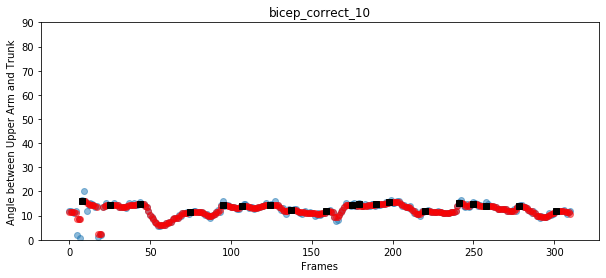

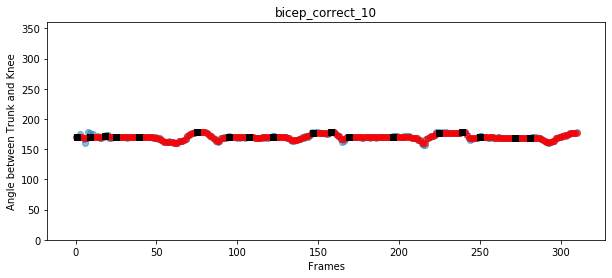

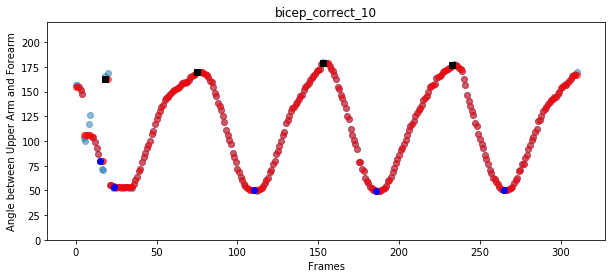

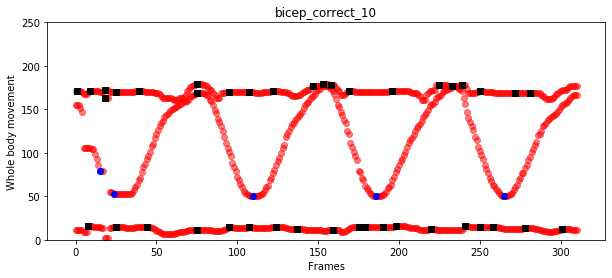

Repetition: 1
Minimum angle between upper arm and forearm: 79.2930066508191
Maximum angle between upper arm and trunk: 15.940260500073242
Maximum angle between trunk and knee: 170.820294598774


Repetition: 2
Minimum angle between upper arm and forearm: 53.04660650807649
Maximum angle between upper arm and trunk: 14.970649131653595
Maximum angle between trunk and knee: 178.23144888017174


Repetition: 3
Minimum angle between upper arm and forearm: 50.73602659413513
Maximum angle between upper arm and trunk: 14.589350087609121
Maximum angle between trunk and knee: 178.650769462795


Repetition: 4
Minimum angle between upper arm and forearm: 49.87618603557552
Maximum angle between upper arm and trunk: 15.442658775413246
Maximum angle between trunk and knee: 177.744060311366


Repetition: 5
Minimum angle between upper arm and forearm: 50.30771548496408
Maximum angle between upper arm and trunk: 15.415886780389865
Maximum angle between trunk and knee: 178.2383216423263


Starting...
Keypoi

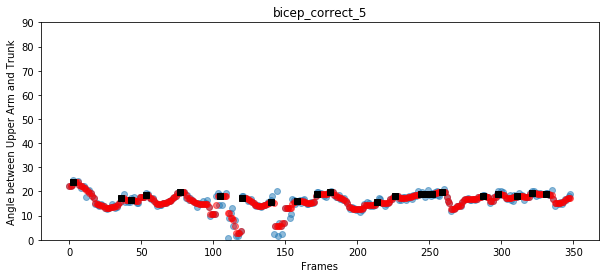

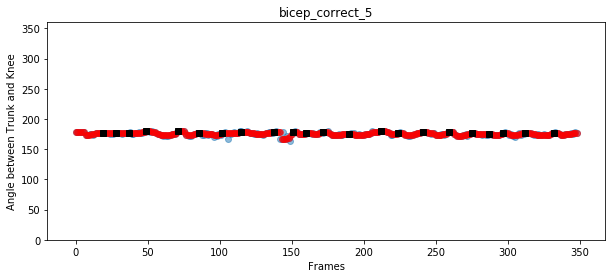

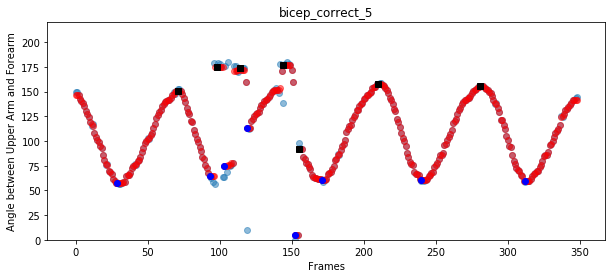

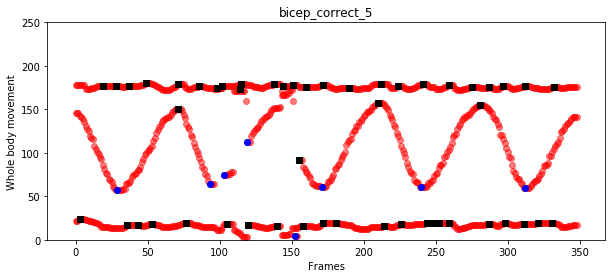

Repetition: 1
Minimum angle between upper arm and forearm: 57.34490479490326
Maximum angle between upper arm and trunk: 23.727871702029525
Maximum angle between trunk and knee: 179.89559855523777


Repetition: 2
Minimum angle between upper arm and forearm: 64.06934211909163
Maximum angle between upper arm and trunk: 19.732983771953702
Maximum angle between trunk and knee: 179.54344087044092


Repetition: 3
Minimum angle between upper arm and forearm: 74.31443206299032
Maximum angle between upper arm and trunk: 18.2324494787654
Maximum angle between trunk and knee: 177.5879008780532


Repetition: 4
Minimum angle between upper arm and forearm: 112.71335984016801
Maximum angle between upper arm and trunk: 17.327536986946367
Maximum angle between trunk and knee: 179.15921818699022


Repetition: 5
Minimum angle between upper arm and forearm: 4.905834089328142
Maximum angle between upper arm and trunk: 13.322222544018244
Maximum angle between trunk and knee: 178.3102939801134


Repetition: 6

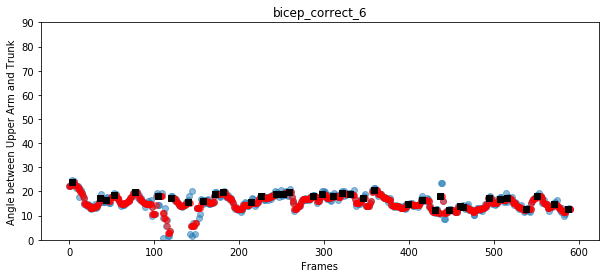

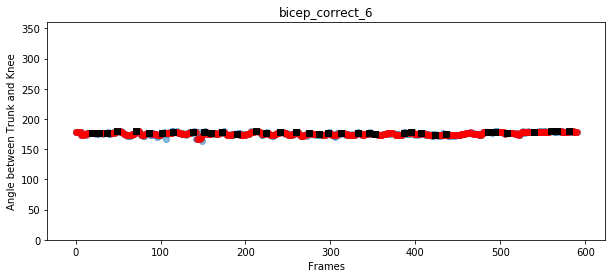

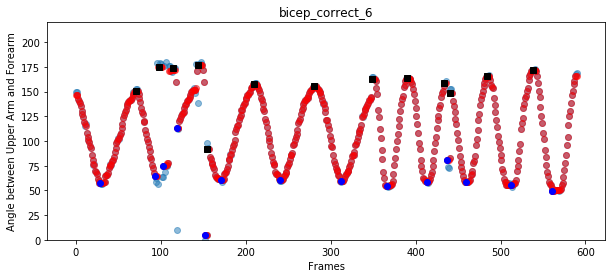

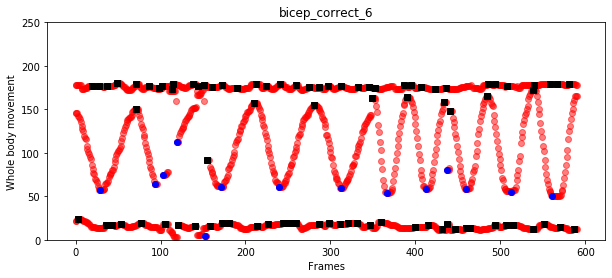

Repetition: 1
Minimum angle between upper arm and forearm: 57.34490479490327
Maximum angle between upper arm and trunk: 23.727871702029493
Maximum angle between trunk and knee: 179.89559855523777


Repetition: 2
Minimum angle between upper arm and forearm: 64.06934211909163
Maximum angle between upper arm and trunk: 19.732983771953702
Maximum angle between trunk and knee: 179.5434408704425


Repetition: 3
Minimum angle between upper arm and forearm: 74.31443206299032
Maximum angle between upper arm and trunk: 18.23244947876536
Maximum angle between trunk and knee: 177.5879008780532


Repetition: 4
Minimum angle between upper arm and forearm: 112.71335984016801
Maximum angle between upper arm and trunk: 17.327536986946328
Maximum angle between trunk and knee: 179.15921818699022


Repetition: 5
Minimum angle between upper arm and forearm: 4.90583408932829
Maximum angle between upper arm and trunk: 13.322222544018297
Maximum angle between trunk and knee: 178.3102939801136


Repetition: 6


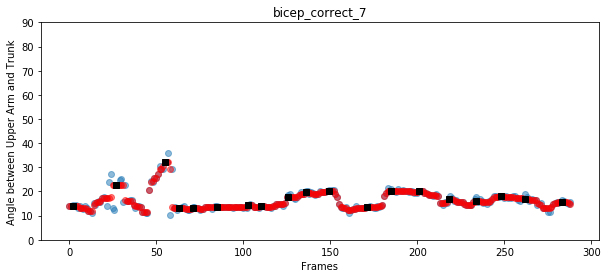

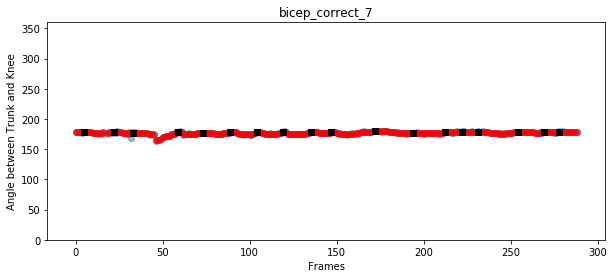

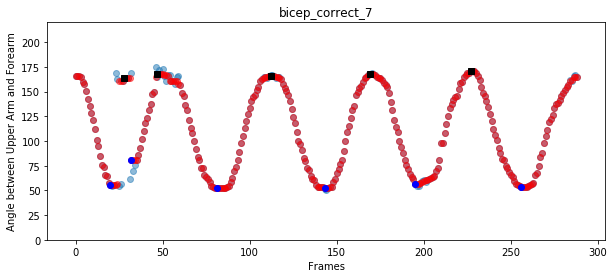

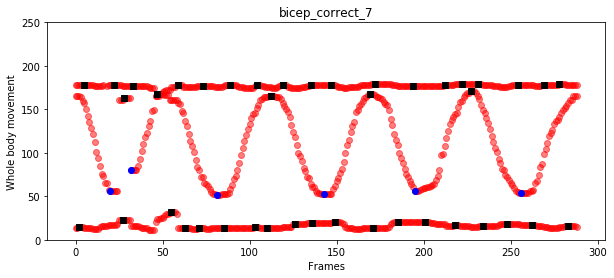

Repetition: 1
Minimum angle between upper arm and forearm: 55.66643207416597
Maximum angle between upper arm and trunk: 22.857440406814735
Maximum angle between trunk and knee: 178.40882359195774


Repetition: 2
Minimum angle between upper arm and forearm: 80.71672410846779
Maximum angle between upper arm and trunk: 20.610616871984586
Maximum angle between trunk and knee: 177.24223458671435


Repetition: 3
Minimum angle between upper arm and forearm: 51.98536936963368
Maximum angle between upper arm and trunk: 32.04434282543907
Maximum angle between trunk and knee: 178.21947406708276


Repetition: 4
Minimum angle between upper arm and forearm: 52.74288828352717
Maximum angle between upper arm and trunk: 20.39376118310953
Maximum angle between trunk and knee: 178.52134760367915


Repetition: 5
Minimum angle between upper arm and forearm: 56.67822681058184
Maximum angle between upper arm and trunk: 20.388259395083466
Maximum angle between trunk and knee: 179.49901619053324


Repetition: 

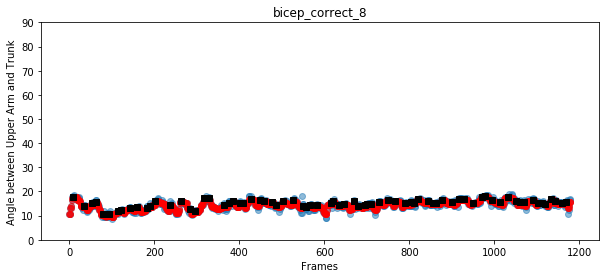

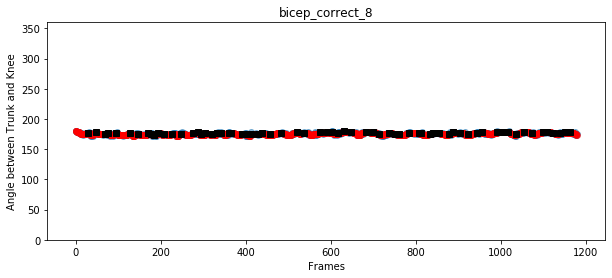

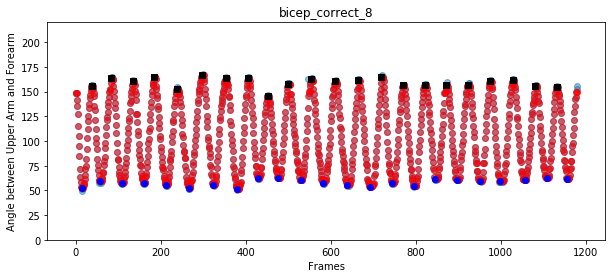

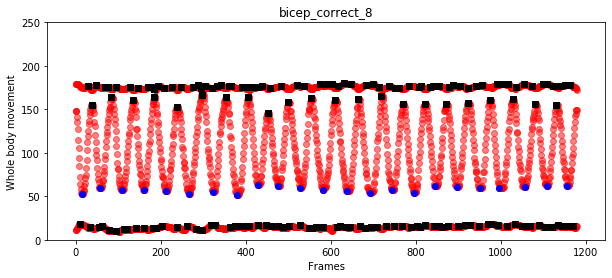

Repetition: 1
Minimum angle between upper arm and forearm: 52.28476162665575
Maximum angle between upper arm and trunk: 17.609243309477737
Maximum angle between trunk and knee: 179.49459575663076


Repetition: 2
Minimum angle between upper arm and forearm: 59.16284362394888
Maximum angle between upper arm and trunk: 15.576634910075907
Maximum angle between trunk and knee: 178.19536679530816


Repetition: 3
Minimum angle between upper arm and forearm: 56.966527333681576
Maximum angle between upper arm and trunk: 12.341906800369866
Maximum angle between trunk and knee: 176.17208672616178


Repetition: 4
Minimum angle between upper arm and forearm: 57.17860602993818
Maximum angle between upper arm and trunk: 13.747707988458025
Maximum angle between trunk and knee: 176.0324785100747


Repetition: 5
Minimum angle between upper arm and forearm: 55.63501548784464
Maximum angle between upper arm and trunk: 16.06354080395719
Maximum angle between trunk and knee: 176.4768013563409


Repetition: 

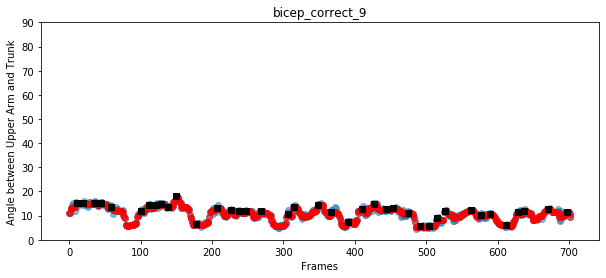

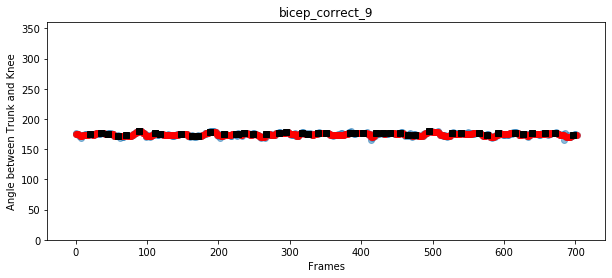

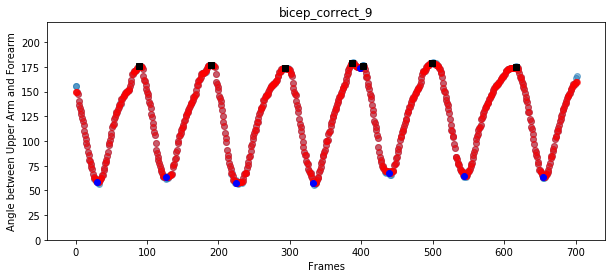

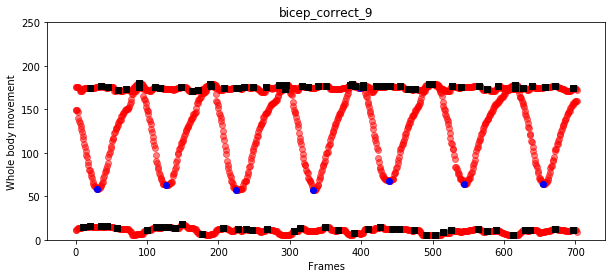

Repetition: 1
Minimum angle between upper arm and forearm: 58.381685131558456
Maximum angle between upper arm and trunk: 15.331496288868632
Maximum angle between trunk and knee: 179.53126676020088


Repetition: 2
Minimum angle between upper arm and forearm: 63.13129283779736
Maximum angle between upper arm and trunk: 18.007632771716636
Maximum angle between trunk and knee: 179.69525778237582


Repetition: 3
Minimum angle between upper arm and forearm: 57.81806724480024
Maximum angle between upper arm and trunk: 13.17683272494198
Maximum angle between trunk and knee: 179.24085039205042


Repetition: 4
Minimum angle between upper arm and forearm: 57.48856905059938
Maximum angle between upper arm and trunk: 14.602921128386505
Maximum angle between trunk and knee: 178.20704028725706


Repetition: 5
Minimum angle between upper arm and forearm: 174.31885396181798
Maximum angle between upper arm and trunk: 7.36280413638721
Maximum angle between trunk and knee: 176.88321850451428


Repetition:

In [3]:
# modify this path for other videos 
# input_folder = "/home/aleko/Documents/Projects/IndividualProject/bicepvid"
# input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all"
input_folder = 'C:\\Users\\ak5u16\\Desktop\\openpose'
folder_paths = glob.glob(os.path.join(input_folder, 'output_points_bicep*'))     

for folder in folder_paths:
    print("Starting..." + "\nKeypoints from folder: " + os.path.basename(folder))
    video_name = os.path.basename(folder).replace('output_points_', '')
    frame_poses = parse_frames(folder)
    joint_angles = JointAngles('bicep curl', frame_poses)
    print('Detected arm: ' + joint_angles.side)

    upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
   
    upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
    
    trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
    trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
    
    # Find upper arm and trunk maximum angles to detect wrong form 
    upArm_trunk_maximas, indexesmax1 = find_extremas(upArm_trunk_angles_filtered)
    # print("Largest angles between upper arm and trunk: " + str(upArm_trunk_maximas))

    # Find trunk and knee maximum angles to detect wrong form 
    trunk_knee_maximas, indexesmax2 = find_extremas(trunk_knee_angles_filtered)
    # print("Largest angles between trunk and knee: " + str(trunk_knee_maximas))

    # Count repetitions
    upArm_forearm_maximas, indexesmax3 = find_extremas(upArm_forearm_angles_filtered)    
    # print("Number of maxima points between Upper Arm and Forearm: " + str(upArm_forearm_maximas.size))
    # print(upArm_forearm_maximas)


    # Find upper arm and forearm minimum points to count reps 
    upArm_forearm_minimas, indexesmin = find_extremas(upArm_forearm_angles_filtered, maxima=False)
    print("Number of reps performed: " + str(upArm_forearm_minimas.size))
    print(upArm_forearm_minimas)

   
    # Plot 1
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90)
    
    # Annontate maxima points
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.show()
    
    # Plot 2
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(trunk_knee_angles.shape[0]), trunk_knee_angles, alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Trunk and Knee')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,360)
    
    # Annontate maxima points
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.show()

    # Plot 3
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles.shape[0]), upArm_forearm_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,220) 
    
    # Annotate minima apoints on the graph   
    max_points = upArm_forearm_angles_filtered[indexesmax3]
    min_points = upArm_forearm_angles_filtered[indexesmin]
    plt.plot(indexesmin, min_points, 'bo')
    plt.plot(indexesmax3, max_points, 'ks')

    """
        # Annotate local maximas
        for maxp, indx in zip(max_points, indexesmax3):
            plt.annotate('local max', xy=(indx, maxp), xytext=(indx, maxp+25),
                    arrowprops=dict(facecolor='black', shrink=0.05))

        # Annotate local minimas
        for minp, indx in zip(min_points, indexesmin):
            plt.annotate('local min', xy=(indx, minp), xytext=(indx, minp-35),
                    arrowprops=dict(facecolor='black', shrink=0.05))     
    """
    plt.show()

    # Plot 4
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Whole body movement')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,250) 
    # Annotate minima apoints      
    plt.plot(indexesmin, upArm_forearm_angles_filtered[indexesmin], 'bo')
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.plot(indexesmax3, upArm_forearm_angles_filtered[indexesmax3], 'ks')
    
    plt.show()
   
    
    # Each rep analysis
    # local minimums for upper arm and forearm are min angles in each rep
    analyse_each_rep(trunk_knee_angles_filtered, upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, upArm_forearm_maximas)

    print('\n' + '='*120 + '\n')